Exact k(x,y): 0.0619, RFF approx: 0.0175


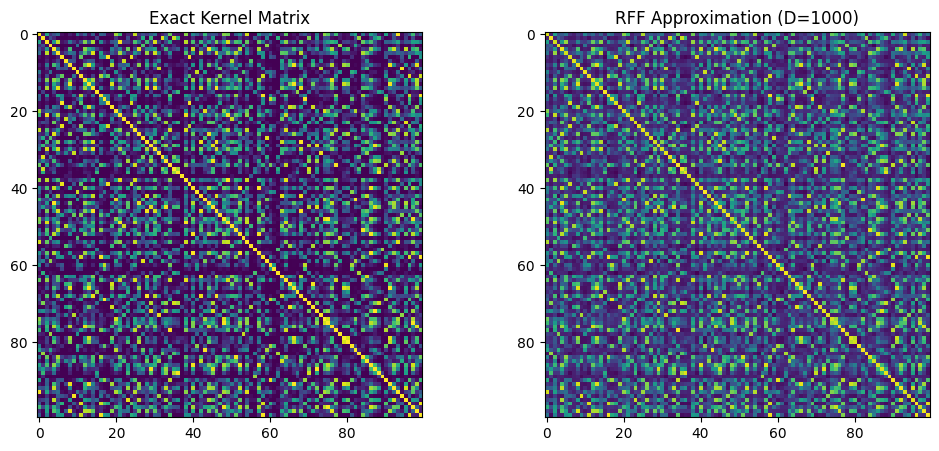

ValueError: operands could not be broadcast together with shapes (100,2) (2,1) 

In [2]:
### **2. random_features.ipynb**
##```python
# %% [markdown]
# # Random Features for Large-Scale Kernel Machines
# 
# **GitHub Project**: [github.com/your-username/random-features-kernel-machines](https://github.com/your-username/random-features-kernel-machines)
# 
# Implementation of the paper ["Random Features for Large-Scale Kernel Machines"](https://people.eecs.berkeley.edu/~brecht/papers/07.rah.rec.nips.pdf) by Rahimi & Recht (NIPS 2007).

# %%
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.linear_model import Ridge
from sklearn.svm import SVC
from time import time

# %% [markdown]
# ## 1. Random Fourier Features (RFF)
# Approximates shift-invariant kernels (e.g., Gaussian RBF) using Monte Carlo sampling from the kernel's Fourier transform.

# %%
# Gaussian RBF kernel and its Fourier transform
gamma = 1.0
kernel = lambda x, y: np.exp(-gamma * np.linalg.norm(x - y)**2)
p_omega = multivariate_normal(mean=np.zeros(2), cov=2*gamma*np.eye(2))

def random_fourier_features(X, D):
    """Generate RFF features for kernel approximation."""
    omega = p_omega.rvs(D)
    b = np.random.uniform(0, 2*np.pi, D)
    return np.sqrt(2/D) * np.cos(X @ omega.T + b)

# Example usage
np.random.seed(42)
X = np.random.randn(100, 2)  # 100 points in 2D
D = 1000
Z_rff = random_fourier_features(X, D)

# Compare exact vs. RFF kernel
x, y = X[0], X[1]
print(f"Exact k(x,y): {kernel(x, y):.4f}, RFF approx: {Z_rff[0] @ Z_rff[1]:.4f}")

# Plot kernel matrices
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow([[kernel(x, y) for x in X] for y in X], cmap='viridis')
plt.title("Exact Kernel Matrix")

plt.subplot(1, 2, 2)
plt.imshow(Z_rff @ Z_rff.T, cmap='viridis')
plt.title(f"RFF Approximation (D={D})")
plt.savefig("assets/rff_comparison.png")  # Save for GitHub
plt.show()

# %% [markdown]
# ## 2. Random Binning Features (RBF)
# Approximates non-smooth kernels (e.g., Laplacian) using random grids.

# %%
def random_binning_features(X, P):
    """Generate RBF features for Laplacian kernel approximation."""
    n, d = X.shape
    Z = np.zeros((n, P))
    for p in range(P):
        delta = np.random.exponential(scale=1.0, size=d)  # p(δ) = δ exp(-δ)
        u = np.random.uniform(0, delta)
        bins = np.floor((X - u) / delta[:, None]).T
        Z[:, p] = np.sum(bins, axis=1)  # Simplified hashing
    return Z / np.sqrt(P)

# Example usage
P = 500
Z_rbf = random_binning_features(X, P)
laplacian_kernel = lambda x, y: np.exp(-np.linalg.norm(x - y, ord=1))
print(f"Exact Laplacian k(x,y): {laplacian_kernel(x, y):.4f}, RBF approx: {Z_rbf[0] @ Z_rbf[1]:.4f}")

# Plot kernel matrices
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow([[laplacian_kernel(x, y) for x in X] for y in X], cmap='viridis')
plt.title("Exact Laplacian Kernel")

plt.subplot(1, 2, 2)
plt.imshow(Z_rbf @ Z_rbf.T, cmap='viridis')
plt.title(f"RBF Approximation (P={P})")
plt.savefig("assets/rbf_comparison.png")  # Save for GitHub
plt.show()

# %% [markdown]
# ## 3. Theoretical Convergence
# Plot error vs. number of features to validate Claims 1-2 from the paper.

# %%
# Simulate convergence for RFF and RBF
Ds = np.logspace(1, 4, 10).astype(int)
errors_rff = [np.linalg.norm(random_fourier_features(X, D) @ random_fourier_features(X, D).T - 
                            [[kernel(x, y) for x in X] for y in X], 'fro') for D in Ds]

Ps = np.logspace(1, 4, 10).astype(int)
errors_rbf = [np.linalg.norm(random_binning_features(X, P) @ random_binning_features(X, P).T - 
              [[laplacian_kernel(x, y) for x in X] for y in X], 'fro') for P in Ps]

plt.figure(figsize=(10, 5))
plt.loglog(Ds, errors_rff, 'o-', label='RFF (Gaussian)')
plt.loglog(Ps, errors_rbf, 's-', label='RBF (Laplacian)')
plt.xlabel("Number of Features (D or P)")
plt.ylabel("Frobenius Error")
plt.title("Uniform Convergence of Random Features")
plt.legend()
plt.grid()
plt.savefig("assets/convergence.png")  # Save for GitHub
plt.show()

# %% [markdown]
# ## 4. Empirical Comparison with SVM
# Compare training time and accuracy of RFF+Ridge vs. exact SVM.

# %%
# Generate synthetic data
X_train = np.random.randn(1000, 10)
y_train = (X_train[:, 0] > 0).astype(int)

# RFF + Ridge
start = time()
Z_train = random_fourier_features(X_train, D=500)
model_rff = Ridge(alpha=1.0).fit(Z_train, y_train)
time_rff = time() - start

# Exact SVM
start = time()
model_svm = SVC(kernel='rbf', gamma=gamma).fit(X_train, y_train)
time_svm = time() - start

print(f"Training Time:\nRFF+Ridge: {time_rff:.2f}s\nSVM: {time_svm:.2f}s")